In [ ]:
! nvidia-smi

In [1]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw14

In [2]:
! pip install -r requirements.txt

In [3]:
import matplotlib.pyplot as plt
import torch

from utils.hw14_utils import *
from meta_learning.protonet import ProtoNet, train

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0
plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Data

Here we will work MNIST dataset which is already preprocessed for meta learning. This dataset comes in a dataloader from. Train loader yields a pair of batch of images (`[2 * N_way * k_shot, 1, 28, 28]`) and batch of labeles (`[2 * N_way * k_shot]`). Where `N_way` means number of classes in each task and `k_shot` means number of samples for each class. Both images and labeles are concatenation of support set (train) and query set (test). You can split them with `split_batch(imgs, targets)`.

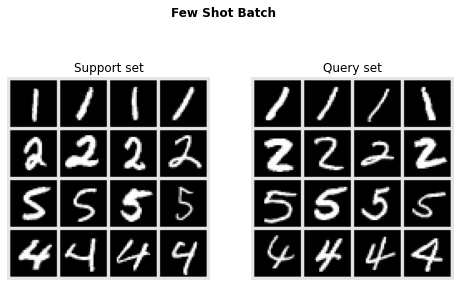

In [6]:
# data sample example
show_imgs()

# Question 1. Prototypical Networks


The Prototypical Network, or [ProtoNet](https://arxiv.org/pdf/1703.05175.pdf) for short, is a metric-based meta-learning algorithm that operates similarly to the nearest neighbor classification. Metric-based meta-learning methods classify a new example $\mathbf{x}$ based on some distance function $d_{\varphi}$ between $x$ and all elements in the support set. ProtoNets implements this idea with the concept of prototypes in a learned feature space. First, ProtoNet uses an embedding function $f_{\theta}$ to encode each input in the support set into a $L$-dimensional feature vector. Next, for each class $c$, we collect the feature vectors of all examples with label $c$ and average their feature vectors. Formally, we can define this as:

$$\mathbf{v}_c=\frac{1}{|S_c|}\sum_{(\mathbf{x}_i,y_i)\in S_c}f_{\theta}(\mathbf{x}_i)$$

where $S_c$ is the part of the support set $S$ for which $y_i=c$, and $\mathbf{v}_c$ represents the _prototype_ of class $c$. The prototype calculation is visualized below for a 2-dimensional feature space and 3 classes. The colored dots represent encoded support elements with the color-corresponding class labels, and the black dots next to the class label are the averaged prototypes. 

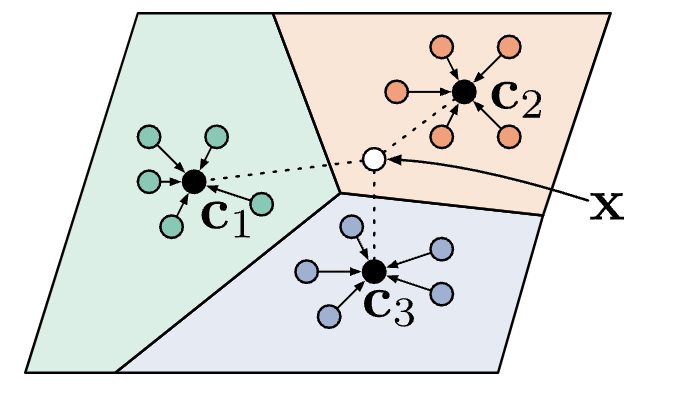

Based on these prototypes, we want to classify a new example. Remember that since we want to learn the encoding function $f_{\theta}$, this classification must be differentiable, and hence, we need to define a probability distribution across classes. For this, we will make use of the distance function $d_{\varphi}$: the closer a new example $\mathbf{x}$ is to a prototype $\mathbf{v}_c$, the higher the probability for $\mathbf{x}$ belonging to class $c$. Formally, we can simply use a softmax over the distances of $\mathbf{x}$ to all class prototypes:

$$p(y=c\vert\mathbf{x})=\text{softmax}(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c))=\frac{\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c)\right)}{\sum_{c'\in \mathcal{C}}\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_{c'})\right)}$$

Note that the negative sign is necessary since we want to increase the probability for close-by vectors and have a low probability for distant vectors. We train the network $f_{\theta}$ based on the cross-entropy error of the training query set examples. Thereby, the gradient flows through both the prototypes $\mathbf{v}_c$ and the query set encodings $f_{\theta}(\mathbf{x})$. For the distance function $d_{\varphi}$, we can choose any function as long as it is differentiable concerning both of its inputs. The most common function, which we also use here, is the squared euclidean distance, but there have been several works on different distance functions as well.


* We will work with 4-way 4-shot classifications during training and 3-way 4-shot classification during test

* You can use architecture from practice

**Hyperparameters**

* lr = 1e-3
* num_epochs = 20



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. Model with a `adapt_few_shots` method

**adapt_few_shots**

```
@torch.no_grad()
def adapt_few_shots(self, batch, dloader):
    """
    batch: n-way_test k-shot_test batch (pair) of images ([k_shot_test * n-way_test, 1, 28, 28]) \\
            and labeles [k_shot_test * n-way_test])
    dloader: dataloader for the test set. yields batches of images ([batch_size, 1, 28, 28])\\
              with their labelel ([batch_size])

     returns pred: np.array of predicted classed for each images in dloader (don't shuffle it)
    """
    
    return pred
```

In [27]:
def q1(train_data_loader):
    """
    train_data_loader: dataloader 4-way 4-shot classification

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - model with a adapt_few_shots method
    """
    model = ProtoNet(embedding_dim=64, hidden_dim=64).to(device)
    model.device = device
    losses = train(model, train_data_loader, device, n_epochs=1, lr=5e-4)

    return losses, model

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1528 [00:00<?, ?it/s]

test accuracy=0.8108


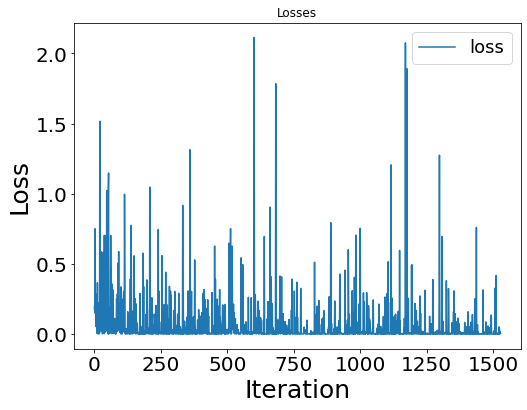

In [28]:
q1_results(q1)

# Bonus. [ProtoMaml](https://arxiv.org/pdf/1903.03096.pdf)

A problem of MAML is how to design the output classification layer. In case all tasks have a different number of classes, we need to initialize the output layer with zeros or randomly in every iteration. Even if we always have the same number of classes, we just start from random predictions. This requires several inner loop steps to reach a reasonable classification result. To overcome this problem we can use prototypes to initialize our output layer to have a strong initialization. Thereby, it can be shown that the softmax over euclidean distances can be reformulated as a linear layer with softmax. To see this, let's first write out the negative Euclidean distance between a feature vector $f_{\theta}(\mathbf{x}^{*})$ of a new data point $\mathbf{x}^{*}$ to a prototype $\mathbf{v}_c$ of class $c$:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})+2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c^T\mathbf{v}_c
$$

We perform the classification across all classes $c\in\mathcal{C}$ and take a softmax on the distance. Hence, any term that is the same for all classes can be removed without changing the output probabilities. In the equation above, this is true for $-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})$ since it is independent of any class prototype. Thus, we can write:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-||\mathbf{v}_c||^2+\text{constant}
$$

Taking a second look at the equation above, it looks a lot like a linear layer. For this, we use $\mathbf{W}_{c,\cdot}=2\mathbf{v}_c$ and $b_c=-||\mathbf{v}_c||^2$ which gives us the linear layer $\mathbf{W}f_{\theta}(\mathbf{x}^{*})+\mathbf{b}$. Hence, if we initialize the output weight with twice the prototypes, and the biases by the negative squared L2 norm of the prototypes, we start with a Prototypical Network. MAML allows us to adapt this layer and the rest of the network further. 

* We will work with 2-way 4-shot classifications during training and 2-way 4-shot classification during test. However, dataloader will yield larger batches, which you need to reshape into `[batch_size, 2 * n-way * k-shot, 1, 28, 28]`

* You can use architecture from practice

* You can use higher or use first order approximation of gradients. This means that the second-order gradients are ignored, and we can calculate the outer loop gradients (line 10 in algorithm 2) simply by calculating the gradients with respect to $\theta_i'$ and use those as an update to $\theta$. Hence, the new update rule becomes:

$$
\theta\leftarrow\theta-\beta\sum_{\mathcal{T}_i\sim p(\mathcal{T})}\nabla_{\theta_i'}\mathcal{L}_{\mathcal{T}_i}(f_{\theta_i'})
$$

Note the change of $\theta$ to $\theta_i'$ for $\nabla$.


**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. Model with a `adapt_few_shots` method

**adapt_few_shots**

```
@torch.no_grad()
def adapt_few_shots(self, batch, dloader):
    """
    batch: n-way_test k-shot_test batch (pair) of images ([k_shot_test * n-way_test, 1, 28, 28]) \\
            and labeles [k_shot_test * n-way_test])
    dloader: dataloader for the test set. yields batches of images ([batch_size, 1, 28, 28])\\
              with their labelel ([batch_size])

     returns pred: np.array of predicted classed for each images in dloader (don't shuffle it)
    """
    
    return pred
```

In [ ]:
def b(train_data_loader):
    """
    train_data_loader: dataloader 16-way 4-shot classification

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - model with a adapt_few_shots method
    """

In [ ]:
b_results(b)